# WEFE Site Analyst
## implemented in Jupyter Notebook

This Jupyter Notebook collects environmental and socioeconomic data for the planning of integrated water, energy, food, and environment systems from open servers.

In [1]:
# imports
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from math import sqrt
import numpy as np
import folium
#import geojson
import overpy
import geemap
import geemap.foliumap as gfolium
import json
import requests
import ee
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON

from geopandas import GeoDataFrame

import shapely
from shapely.geometry import Polygon, shape
from shapely.geometry import LineString


# import files from source
os.chdir("../../src/")
import era5
import ee_layer
os.chdir("../examples/Malaysia")

In [2]:
# set start and end date (end date will be included
# in the time period for which data is downloaded)
start_date, end_date = '2022-01-01', '2022-12-31'  # time in UTC choose start date one day before time of interest
# for position east of 0° meridian for covering all hours of interest

In [3]:
# initiate earth engine


# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AfJohXmJbXw2bRgKq8wAcOwDmE2UfOf1W0ioh7Z_qRd8SqhZ8RhrwB0frOs

Successfully saved authorization token.


In [10]:
# provide case study name and coordiantes

name = 'Frangipani_Langkawi'
lat = 6.2794116744592685
lon = 99.73116488004294

center = ee.Geometry.Point(lon, lat)

# visualization as geemap
map = geemap.Map(center=[lat, lon], zoom=16)
map.add_basemap('SATELLITE')
map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")
# map.add_layer(json_shape_layer)


map



Map(center=[6.2794116744592685, 99.73116488004294], controls=(WidgetControl(options=['position', 'transparent_…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [5]:
# retrieve area of interest from drawing/alternative in case polygon file is not available


center = ee.Geometry.Point(lon, lat)

print("please draw center of demand and area of interest into the map displayed below")


m = gfolium.Map(
    center=[lat, lon], zoom=17, toolbar_control=False, layers_control=True
)

m.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")
m.add_basemap('SATELLITE')

m


please draw center of demand and area of interest into the map displayed below


In [6]:
## TERRAIN MAP
# Define the location for which you want to create the elevation map (given abo)

center = ee.Geometry.Point(lon, lat)
buffer = center.buffer(3000)


# Get the elevation at the map center
elevation = ee.Image('USGS/SRTMGL1_003').sample(center)

# Get the elevation value at the map center
elevation_value = elevation.get('elevation').getInfo()

# Print the elevation value
print(f'Elevation at {lon}, {lat}: {elevation_value} meters')


# Create a geemap map centered on the location
terrain_map = geemap.Map(center=[lat, lon], zoom=16)


# Use the 'SRTM 30m Digital Elevation Database' dataset to get elevation dataset

elevation = ee.Image('USGS/SRTMGL1_003').clip(buffer);
slope = ee.Terrain.slope(elevation);

# Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
aspect = ee.Terrain.aspect(elevation);
terrain = ee.Terrain.products(elevation);

vis_params = {
    'min': 0,
    'max': 200,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

vis_params_slope = {
    'min': 0,
    'max': 20,
    'palette': ['FFFFFF', '000000'],
}
terrain_map.add_basemap('SATELLITE')
terrain_map.addLayer(slope,{'min': 0, 'max': 20, 'palette': ['FFFFFF', '000000']}, 'Slope')
terrain_map.addLayer(aspect,{'min': 0, 'max': 360, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}, 'Aspect')
terrain_map.addLayer(terrain.select('hillshade'), {min: 0, max: 255}, 'Hillshade')
terrain_map.addLayer(elevation, vis_params, 'Elevation')
terrain_map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")



# Make pixels with elevation below sea level transparent -> please implement
# elv_img = srtm.updateMask(srtm.gt(0))

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

terrain_map.add_colorbar_branca(vis_params = vis_params, colors=colors, vmin=vmin, vmax=vmax, layer_name="Elevation")
#terrain_map.add_colorbar_branca(vis_params = vis_params_slope, colors = vis_params_slope['palette'], vmin= vis_params_slope['min'], vmax= vis_params_slope['max'], layer_name="slope")

# Display the map
terrain_map


Elevation at 99.73116488004294, 6.2794116744592685: None meters


Map(center=[6.2794116744592685, 99.73116488004294], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
## LANDUSE MAP
# Define the location for which you want to create the map

center = ee.Geometry.Point(lon, lat)
buffer = center.buffer(3000)

landuse_map = gfolium.Map(center=[lat, lon], zoom=17)
dataset = ee.ImageCollection("ESA/WorldCover/v100").first()
landuse_map.add_basemap('SATELLITE')
landuse_map.addLayer(dataset, {'bands': ['Map']}, 'ESA Land Cover')
landuse_map.add_legend(builtin_legend='ESA_WorldCover')
landuse_map.addLayer(center,{'color': 'cyan', 'weight': 1, 'opacity': 1}, "center")
landuse_map

In [13]:
import folium
import overpy

bbox_size = 0.001

# Calculate the bounds of the bounding box
bounds = [lat-bbox_size, lon-bbox_size, lat+bbox_size, lon+bbox_size]

# Connect to the Overpass API
api = overpy.Overpass()

# Query for all water areas including rivers, creeks, reservoirs, etc. within the bounding box
query = f"""
    way["waterway"~"river|stream|canal|ditch|drain|brook|creek|reservoir"]({bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]});
    (._;>;);
    out body;
"""

# Execute the query
result = api.query(query)

# Create a Folium map centered at the center of the bounding box
m = folium.Map(location=[lat, lon], zoom_start=14, Tiles=None)

# Add the water bodies to the map
for way in result.ways:
    folium.PolyLine(locations=[(node.lat, node.lon) for node in way.nodes], color="blue", weight=2.5, opacity=1).add_to(m)

# Display the map
m


In [ ]:
# Hydrology Map

center = ee.Geometry.Point(lon, lat)

# water sources
lon_dw = 
lat_dw = 

lon_pw1 = 
lat_pw1 = 

#lon_pw2 =
#lat_pw2 =

dws1 = ee.Geometry.Point(lon_dw, lat_dw)
pws1 = ee.Geometry.Point(lon_pw1, lat_pw1)
#pws2 = ee.Geometry.Point(lon_pw2, lat_pw2)

hm = gfolium.Map(
    center=[lat, lon], zoom=17, toolbar_control=False, layers_control=True
)

hm.add_basemap('SATELLITE')

hm.addLayer(center, {'color': 'cyan', 'weight': 1, 'opacity': 0.7}, "center")
hm.addLayer(dws1, {'color':'blue', 'weight':1, 'opacity':0.7}, "drinking water source")
hm.addLayer(pws1, {'color':'cyan', 'weight':1, 'opacity':0.7}, "livestock water source 1")


hm.add_osm_from_point(
    center_point=(lat, lon),
    tags={"natural": "water"},
    dist=5000,
    layer_name="Lakes",
)
hm.add_osm_from_point(
    center_point=(lat, lon),
    tags={"waterway":["river", "stream", "tidal_channel", "canal", "ditch", "drain", "pressurized"]},
    dist=5000,
    layer_name="waterway",
)

hm


# "amenity":"drinking_water"
#waterway=river waterway=streamwaterway=tidal_channel waterway=canal waterway=ditch waterway=drain waterway=pressurised
#natural=water
#water=*


In [11]:
## Soil Properties

#soil organic carbon
soc_mean = ee.Image("projects/soilgrids-isric/soc_mean")
print(type(soc_mean))

# Soil salinity
# Soil depth
# soil bulk density
bdod_mean = ee.Image("projects/soilgrids-isric/bdod_mean")
# Soil Cation Exchange Capacity
cec_mean = ee.Image("projects/soilgrids-isric/cec_mean")
# Soil moisture
#nitrogen
nitrogen_mean = ee.Image("projects/soilgrids-isric/nitrogen_mean")
# Soil pH (in H2O)
phh2o_mean = ee.Image("projects/soilgrids-isric/phh2o_mean")
# soil texture
clay_mean = ee.Image("projects/soilgrids-isric/clay_mean")
silt_mean = ee.Image("projects/soilgrids-isric/silt_mean")
sand_mean = ee.Image("projects/soilgrids-isric/sand_mean")

location = {
  "type": "Point",
  "coordinates": [lon, lat]
}

# Extract the soil properties for the location
soc_mean = soc_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

bdod_mean = bdod_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

cec_mean = cec_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

nitrogen_mean = nitrogen_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

phh2o_mean = phh2o_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

clay_mean = clay_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

silt_mean = silt_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()
index_list = ['0-5cm', '100-200cm', '15-30cm', '30-60cm', '5-15cm', '60-100cm']

sand_mean = sand_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

# Convert the soil properties to a pandas dataframe
soc_mean_df = pd.DataFrame.from_dict(soc_mean, orient='index', columns=["soil organic carbon [dg/kg]"])
soc_mean_df['soil_depth'] = index_list
soc_mean_df = soc_mean_df.set_index(keys='soil_depth')

bdod_mean_df = pd.DataFrame.from_dict(bdod_mean, orient='index', columns=["bulk density [cg/cm³]"])
bdod_mean_df['soil_depth'] = index_list
bdod_mean_df = bdod_mean_df.set_index(keys='soil_depth')

cec_mean_df  = pd.DataFrame.from_dict(cec_mean, orient='index', columns=["cation exchange capacity at pH 7 [mmol(c)/kg]"])
cec_mean_df['soil_depth'] = index_list
cec_mean_df = cec_mean_df.set_index(keys='soil_depth')

nitrogen_mean_df = pd.DataFrame.from_dict(nitrogen_mean, orient='index', columns=["nitrogen content [cg/kg]"])
nitrogen_mean_df['soil_depth'] = index_list
nitrogen_mean_df = nitrogen_mean_df.set_index(keys='soil_depth')

phh2o_mean_df = pd.DataFrame.from_dict(phh2o_mean, orient='index', columns=["pH of soil water [pH*10]"])
phh2o_mean_df['soil_depth'] = index_list
phh2o_mean_df = phh2o_mean_df.set_index(keys='soil_depth')

clay_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["clay content [g/kg]"])
clay_mean_df['soil_depth'] = index_list
clay_mean_df = clay_mean_df.set_index(keys='soil_depth')

silt_mean_df = pd.DataFrame.from_dict(silt_mean, orient='index', columns=["silt content [g/kg]"])
silt_mean_df['soil_depth'] = index_list
silt_mean_df = silt_mean_df.set_index(keys='soil_depth')

sand_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["sand content [g/kg]"])
sand_mean_df['soil_depth'] = index_list
sand_mean_df = sand_mean_df.set_index(keys='soil_depth')

soil_properties_df = pd.concat((soc_mean_df, bdod_mean_df, cec_mean_df, nitrogen_mean_df, phh2o_mean_df, clay_mean_df, silt_mean_df, sand_mean_df), axis=1)
print(soil_properties_df)


def soil_texture(row):
    clay =row["clay content [g/kg]"]
    silt =row["silt content [g/kg]"]
    sand =row["sand content [g/kg]"]
    
    total = clay + silt + sand
    clay_percent = clay / total * 100
    silt_percent = silt / total * 100
    sand_percent = sand / total * 100

    if sand_percent >= 50:
        return "Sand"
    elif silt_percent >= 50:
        return "Silt"
    elif clay_percent >= 50:
        return "Clay"
    elif sand_percent >= 30:
        return "Sandy Loam"
    elif silt_percent >= 30:
        return "Silt Loam"
    elif clay_percent >= 30:
        return "Clay Loam"
    else:
        return "Loam"


soil_properties_df["soil texture"] = soil_properties_df.apply(soil_texture, axis=1)
print(soil_properties_df)


soil_properties_df.to_csv('soil_properties_'+name+'.csv', index = True)



<class 'ee.image.Image'>
           soil organic carbon [dg/kg] bulk density [cg/cm³]   
soil_depth                                                     
0-5cm                             None                  None  \
100-200cm                         None                  None   
15-30cm                           None                  None   
30-60cm                           None                  None   
5-15cm                            None                  None   
60-100cm                          None                  None   

           cation exchange capacity at pH 7 [mmol(c)/kg]   
soil_depth                                                 
0-5cm                                               None  \
100-200cm                                           None   
15-30cm                                             None   
30-60cm                                             None   
5-15cm                                              None   
60-100cm                                  

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [12]:
# download era5 dataset

variable = "wefesiteanalyst"
target_file = 'era5_wefesiteanalyst_'+name+'.nc'
print(target_file)


ds = era5.get_era5_data_from_datespan_and_position(
    variable=variable,
    start_date=start_date, end_date=end_date,
    latitude=lat, longitude=lon,
    target_file=target_file)

era5_wefesiteanalyst_Frangipani_Langkawi.nc


2024-01-05 11:19:35,195 INFO Welcome to the CDS
2024-01-05 11:19:35,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-01-05 11:19:35,415 INFO Request is queued
2024-01-05 11:20:50,720 INFO Request is running
2024-01-05 12:03:57,166 INFO Request is completed
2024-01-05 12:03:57,166 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.mars.internal-1704452192.8659132-14294-9-35b6bce3-7f67-4290-bfe7-e15e7bccf3b3.nc to era5_wefesiteanalyst_Frangipani_Langkawi.nc (139.3K)
2024-01-05 12:03:57,526 INFO Download rate 393.8K/s                                                                    


In [14]:
# File transformation nc to csv
ds = xr.open_dataset('era5_wefesiteanalyst_'+name+'.nc')
era5_wefe = ds.to_dataframe()
# transform time: Costa Rica Time: UTC -6
# Create a date range with the desired starting date and frequency
#print(era5_wefe)
date_range = pd.date_range(start='2022-01-01 00:00:00', freq='H', periods=len(era5_wefe))
# Set the date range as the index of the DataFrame
era5_wefe.set_index(date_range, inplace=True)
# print(era5_wefe)
# print(era5_wefe.dtypes)
# convert units
# global horizontal irradiance
era5_wefe['ghi'] = (era5_wefe['ssrd'] / 3600.0)
era5_wefe['t_air'] = era5_wefe['t2m']-273.15
era5_wefe['e'] *=1000
era5_wefe['tp']*=1000


def calc_sqrt_sum_squares(df, col1, col2):
    return np.sqrt(df[col1]**2 + df[col2]**2)

era5_wefe['windspeed'] = calc_sqrt_sum_squares(era5_wefe, 'u10', 'v10')

# create new dataframe only consisting out of data for required parameters

columns = ['ghi', 't_air', 'e', 'tp', 'windspeed']
values = era5_wefe[columns].values
ep = pd.DataFrame(values, columns=columns, index = era5_wefe.index)


print(ep)
#print(ep.dtypes)

ep.to_csv('era5_wefesiteanalyst_'+name+'.csv', index=True)


                            ghi      t_air         e        tp  windspeed
2022-01-01 00:00:00    8.071806  26.328796 -0.202973  0.006672   6.829267
2022-01-01 01:00:00   98.118889  26.525848 -0.221671  0.004277   6.698661
2022-01-01 02:00:00  264.620209  27.460419 -0.261042  0.002395   7.893950
2022-01-01 03:00:00  427.240021  28.038239 -0.301447  0.027202   7.797009
2022-01-01 04:00:00  564.467896  28.767242 -0.325292  0.001369   7.742539
...                         ...        ...       ...       ...        ...
2022-12-31 19:00:00   -0.000417  25.509460 -0.147594  0.000000   5.345788
2022-12-31 20:00:00   -0.000417  25.257446 -0.153392  0.000000   5.591700
2022-12-31 21:00:00   -0.000417  25.229187 -0.158037  0.000000   5.363720
2022-12-31 22:00:00   -0.000417  25.085785 -0.159530  0.000000   5.369678
2022-12-31 23:00:00   -0.000417  24.963715 -0.158192  0.000000   5.334292

[8760 rows x 5 columns]


In [15]:
#era5_wefe = pd.read_csv(r"wefe.csv")
ep.head()
print(ep['ghi'].sum())
print(ep['t_air'].mean())
print(ep['tp'].sum())
print(ep['windspeed'].mean())

1947269.8
27.78566
2440.8489
2.9854383


Text(0, 0.5, 'Irradiance in $W/m^2$')

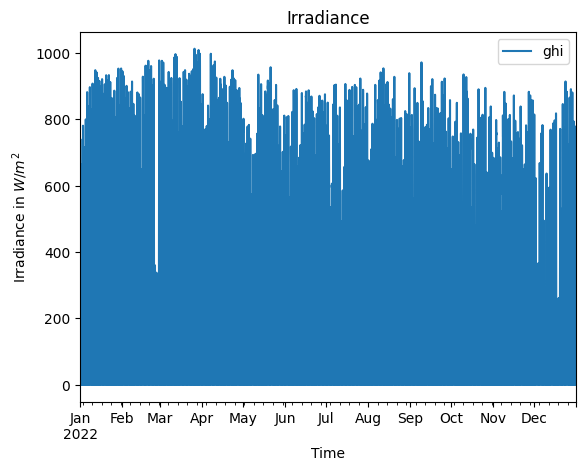

In [16]:
# global horizontal irradiance
era5_wefe.loc[:, ['ghi']].plot(title='Irradiance')
plt.xlabel('Time')
plt.ylabel('Irradiance in $W/m^2$')

Text(0, 0.5, 'Total Precipitation in $m³/h$')

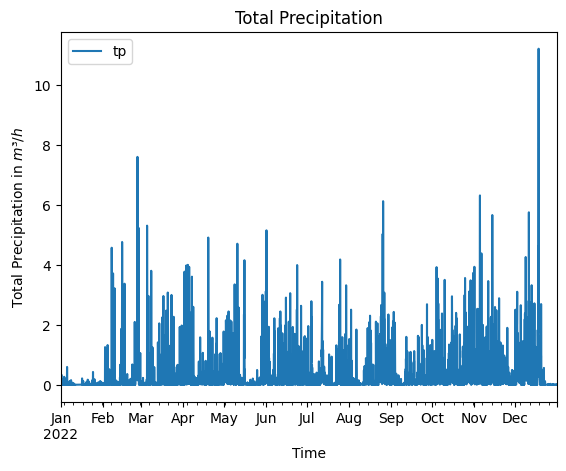

In [17]:
# plot total precipitation
era5_wefe.loc[:, ['tp']].plot(title='Total Precipitation')
plt.xlabel('Time')
plt.ylabel('Total Precipitation in $m³/h$')

Text(0, 0.5, 'Air Temperature in $°C$')

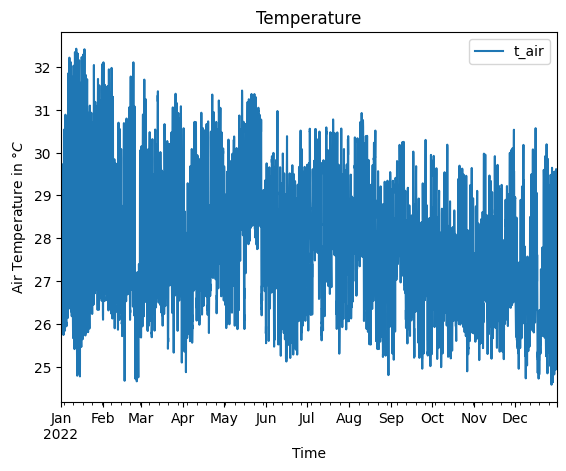

In [18]:
# plot temperature
era5_wefe.loc[:, ['t_air']].plot(title='Temperature')
plt.xlabel('Time')
plt.ylabel('Air Temperature in $°C$')